In [1]:
!pip install tensorflow matplotlib numpy


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

tf.random.set_seed(42)
np.random.seed(42)


In [3]:
EPOCHS = 80
BATCH_SIZE = 128
NOISE_DIM = 100
LR = 0.0002
SAVE_INTERVAL = 10


In [4]:
(x_train, _), _ = fashion_mnist.load_data()

x_train = (x_train.astype("float32") - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

BUFFER_SIZE = x_train.shape[0]
dataset = tf.data.Dataset.from_tensor_slices(x_train)\
            .shuffle(BUFFER_SIZE)\
            .batch(BATCH_SIZE, drop_remainder=True)

IMG_SHAPE = x_train.shape[1:]


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, 5, strides=2, padding='same',
                               use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same',
                      input_shape=IMG_SHAPE),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

gen_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)


In [8]:
@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

        real_loss = cross_entropy(tf.ones_like(real_output)*0.9, real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [9]:
os.makedirs("generated_samples", exist_ok=True)

def generate_and_save_images(epoch):
    noise = tf.random.normal([25, NOISE_DIM])
    predictions = generator(noise, training=False)
    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(5,5))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}", fontsize=12)
    plt.savefig(f"generated_samples/epoch_{epoch}.png")
    plt.close()


In [10]:
for epoch in range(1, EPOCHS + 1):
    for image_batch in dataset:
        g_loss, d_loss = train_step(image_batch)

    if epoch % SAVE_INTERVAL == 0:
        generate_and_save_images(epoch)
        print(f"Epoch {epoch} | G_loss: {g_loss:.3f} | D_loss: {d_loss:.3f}")


Epoch 10 | G_loss: 0.952 | D_loss: 1.282
Epoch 20 | G_loss: 0.954 | D_loss: 1.287
Epoch 30 | G_loss: 0.904 | D_loss: 1.299
Epoch 40 | G_loss: 0.948 | D_loss: 1.289
Epoch 50 | G_loss: 0.838 | D_loss: 1.347
Epoch 60 | G_loss: 0.925 | D_loss: 1.373
Epoch 70 | G_loss: 0.865 | D_loss: 1.322
Epoch 80 | G_loss: 0.865 | D_loss: 1.315


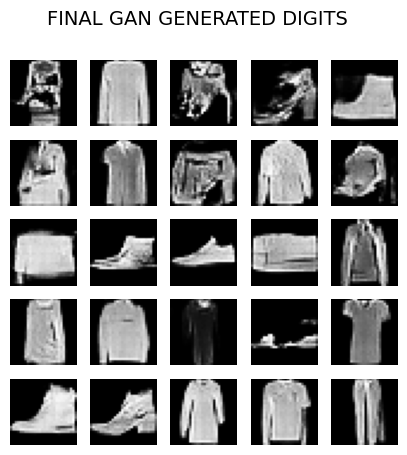

In [11]:
noise = tf.random.normal([25, NOISE_DIM])
final_images = generator(noise, training=False)
final_images = (final_images + 1) / 2.0

plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(final_images[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.suptitle("FINAL GAN GENERATED DIGITS", fontsize=14)
plt.show()


In [12]:
import shutil

folder_name = "generated_samples"
zip_name = "generated_samples.zip"

shutil.make_archive("generated_samples", 'zip', folder_name)
print("ZIP created:", zip_name)


ZIP created: generated_samples.zip


In [13]:
from google.colab import files

files.download("generated_samples.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>